In [ ]:
pip install timm

In [ ]:
pip install gradio

In [ ]:
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
import timm
import torch
import torch.nn as nn
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import gradio as gr

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# Define prepocessing
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),  # Required for Swin Transformer input size
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

In [ ]:
# Load CIFAR-100 dataset
train_dataset = CIFAR10(root='./data', train=True, transform=transform, download=True)
test_dataset = CIFAR10(root='./data', train=False, transform=transform, download=True)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False, num_workers=4)


In [ ]:
# Load pretrained Swin Transformer model
model = timm.create_model('swin_tiny_patch4_window7_224', pretrained=True)
model.head = nn.Identity()  # Remove the classification head to get embeddings

model = model.to(device).eval()


In [ ]:
# Function to extract features from the model
def extract_features(model, data_loader):
    features = []
    labels = []
    
    with torch.no_grad():  # No gradient calculation for inference
        for images, targets in data_loader:
            images = images.to(device)  # Move images to the correct device
            outputs = model(images)  # Get the model's output (features)
            #print(len(outputs))
            features.append(outputs.cpu())  # Store features (tensors) on CPU
            labels.append(targets.cpu())  # Store labels on CPU
            
    features = torch.cat(features, dim=0)  # Concatenate all features into a single tensor
    labels = torch.cat(labels, dim=0)  # Concatenate all labels into a single tensor
    return features, labels

# Extract features for train and test data
train_features, train_labels = extract_features(model, train_loader)
test_features, test_labels = extract_features(model, test_loader)

In [42]:
from sklearn.metrics.pairwise import cosine_similarity

def find_similar_images(query_feature, dataset_features, top_k=5):
    # Reshape features to 2D arrays
    query_feature = query_feature.view(query_feature.size(0), -1).cpu().numpy()  # Shape: (1, feature_length)
    dataset_features = dataset_features.view(dataset_features.size(0), -1).cpu().numpy()  # Shape: (N, feature_length)
    
    # Compute cosine similarities
    similarities = cosine_similarity(query_feature, dataset_features)  # Shape: (1, N)
    
    # Find indices of top-k most similar images
    top_k_indices = similarities[0].argsort()[-top_k:][::-1]
    
    return top_k_indices.tolist(), similarities[0][top_k_indices].tolist()  # Indices and scores


In [57]:
import matplotlib.pyplot as plt

def show_images(indices, dataset, title="Images"):
    num_images = len(indices)
    
    # Create a subplot with one column per image to display
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    
    # Ensure axes is always iterable (handles the case where only one image is shown)
    if num_images == 1:
        axes = [axes]  # Wrap single Axes object into a list
    
    # Plot images
    for ax, idx in zip(axes, indices):
        image, _ = dataset[idx]  # Get the image and label from the dataset
        
        # Convert the image from (C, H, W) to (H, W, C) format for displaying
        image = image.permute(1, 2, 0).numpy()  # Convert to numpy array in (H, W, C) format
        
        # Display the image directly
        ax.imshow(image)  
        ax.axis("off")  # Hide the axes for a cleaner view
    
    plt.suptitle(title)  # Add a title to the overall plot
    plt.show()  # Display the plot



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


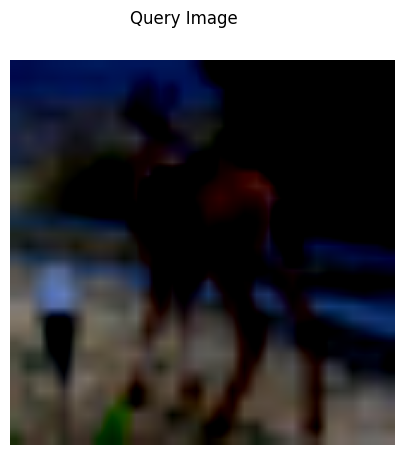

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Cosine Similarity Scores: [0.5173049569129944, 0.4928595721721649, 0.4767226278781891, 0.46985501050949097, 0.4626946449279785]


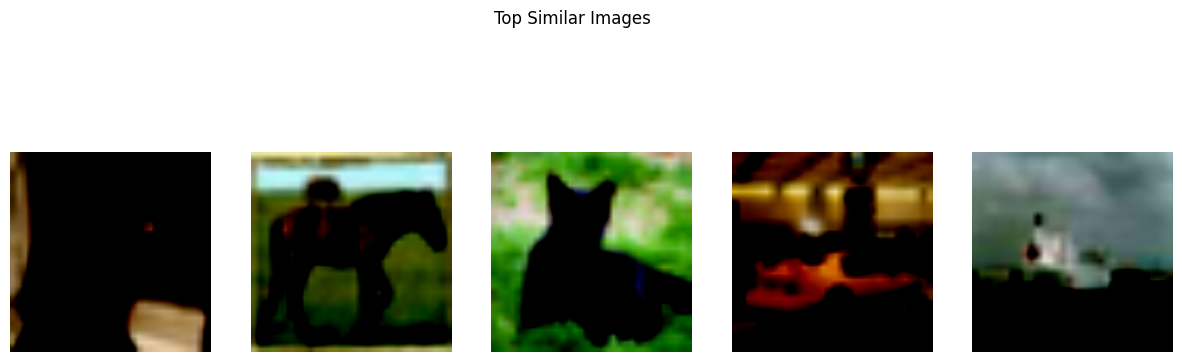

In [79]:
query_idx = 100
query_feature = test_features[query_idx].unsqueeze(0)
top_indices, scores = find_similar_images(query_feature, train_features)

# Display query image
show_images([query_idx], test_dataset, title="Query Image")

# Display top similar images
print("Cosine Similarity Scores:", scores)
show_images(top_indices, train_dataset, title="Top Similar Images")

In [80]:
def get_similar_images(input_image):
    # Preprocess input image
    input_tensor = transform(input_image).unsqueeze(0).to(device)
    
    # Extract feature from input image
    with torch.no_grad():
        query_feature = model(input_tensor).cpu()
    
    top_indices, _ = find_similar_images(query_feature, train_features)
    
    # Return only similar images (not including the input image)
    similar_images = [transforms.ToPILImage()(train_dataset[idx][0]) for idx in top_indices]
    return similar_images

In [81]:
with gr.Blocks() as iface:
    with gr.Row():
        # Input image
        input_image = gr.Image(type="pil", label="Input Image")
        
        # Display similar images in separate output components
        outputs = [gr.Image(type="pil", label=f"Similar Image {i+1}") for i in range(5)]
    
    # When the input image is changed, the function get_similar_images is called
    input_image.change(fn=get_similar_images, inputs=input_image, outputs=outputs)

iface.launch(share=True)

* Running on local URL:  http://127.0.0.1:7877
* Running on public URL: https://ca7b5f37054b5fd186.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
